In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.10.0


 Understanding tensorflow and how images are stored

 When you read an image file in, it is stored as an array with shape (X, Y, Z)
 You can think of this as an array with X rows, Y columns and each element in that X-by-Y array
 is a Z dimensional array (i.e., has Z elements). This is a rank 3 tensor. For more information about a tensor
 check out https://www.tensorflow.org/guide/tensor

 Now, we have a rank 3 tensor, in terms of the image: 
 the X component corresponds to the height
 the Y component corresponds to the width
 the Z component corresponds to the channels

 Channels simply refer to color information of the image, 
 e.g. channel = 1 is a black/white image, channel = 3 is an RGB image


 In the example below, we will be using an image with shape (256, 512, 3)
 that means it is an image that is twice as long as it is tall, and it is an RGB/colored image.

Below is the original image, no splicing


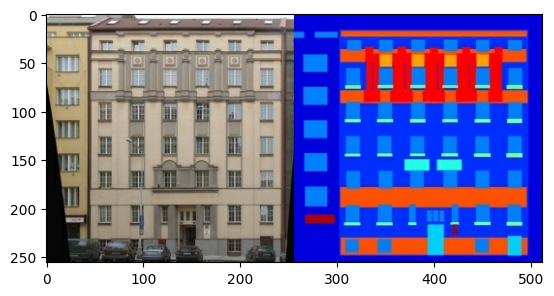

Below is the image with shape (:, :256, :) - that is, we cut the width in half


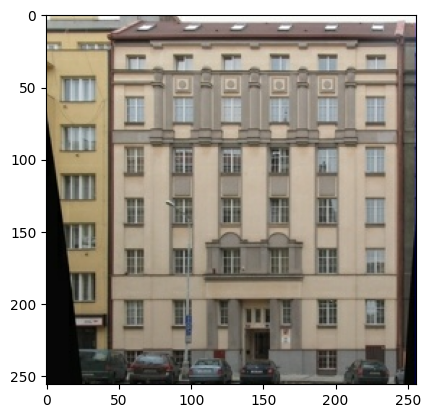

Below is the image with shape (:128, :, :) - that is, we cut the height in half


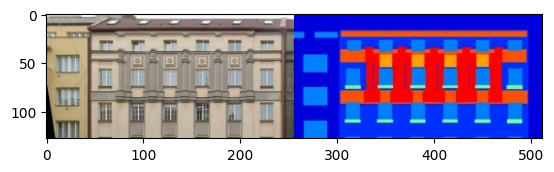

Below is the image with shape (:, :, :1) - that is, we made it gray scaled


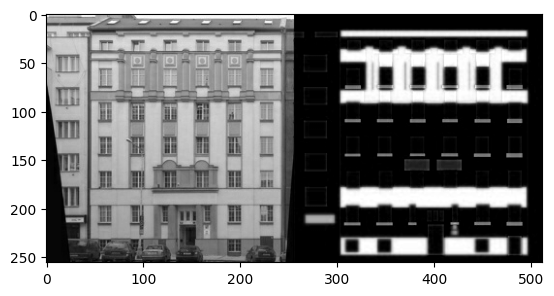

 Examining the image above, we learned something incredibly important:
 the images are draw starting from the top left. i.e. [0,0] is the top left coordinate


In [3]:
image = tf.io.read_file('1.jpg')
image = tf.io.decode_jpeg(image, channels = 3)

# Original image
print('Below is the original image, no splicing')
plt.imshow(image[:,:,:]) #the image shape is height, width, channels (channels correspond to colors)
plt.show()

# Width Splice
print('Below is the image with shape (:, :256, :) - that is, we cut the width in half')
plt.imshow(image[:,:256,:]) 
plt.show()

# Height Splice
print('Below is the image with shape (:128, :, :) - that is, we cut the height in half')
plt.imshow(image[:128,:,:]) 
plt.show()

# Channel Splice
print('Below is the image with shape (:, :, :1) - that is, we made it gray scaled')
plt.imshow(image[:,:,:1], cmap='gray') 
plt.show()

print(""" Examining the image above, we learned something incredibly important:
 the images are draw starting from the top left. i.e. [0,0] is the top left coordinate""")

In [4]:
def image_processor(image, buffer=0):
    im_width = len(image[0])
    im_height = len(image[:][0])

    new_im = image[buffer:(im_width-buffer),
                     buffer:(im_height-buffer),:]
    plt.imshow(new_im)
    plt.show()
    plt.imshow(image)
    return new_im

As described in the [pix2pix paper](https://arxiv.org/abs/1611.07004), you need to apply random jittering and mirroring to preprocess the training set.

Define several functions that:

1. Resize each `256 x 256` image to a larger height and width—`286 x 286`.
2. Randomly crop it back to `256 x 256`.
3. Randomly flip the image horizontally i.e., left to right (random mirroring).
4. Normalize the images to the `[-1, 1]` range.

In [22]:
def resize(input_image, height, width):
    return tf.image.resize(input_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

def random_crop(input_image, height, width):
    return tf.image.random_crop(input_image, size=[height, width, 3])

# Normalizing the images to [-1, 1]
def normalize(input_image):
    input_image = tf.cast(input_image, dtype=tf.float32)
    input_image = (input_image / 127.5) - 1
    #input_image = input_image / 255.0
    return input_image

def inverse_normalize(input_image):
    input_image = tf.cast(input_image, dtype=tf.float32)
    input_image = (input_image + 1) * 127.5
    #input_image = input_image * 255.0
    input_image = tf.cast(input_image, dtype=tf.uint8)
    return input_image

@tf.function()
def random_jitter(input_image):
    # Resizing to 286x286
    input_image = resize(input_image, 286, 286)
    
    # Random cropping back to 256x256
    input_image= random_crop(input_image, 256, 256)
    
    # Random mirroring
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
    
    # Normalizing image
    input_image = normalize(input_image)
    return input_image

Using the functions defined above, as provided by Tensorflow, the image pre-processing routine will be:

1. Use the random_jitter function to add noise to our input images for both discriminator and generator
2. Use the image_processor function to get the cropped image for the generator
3. Send the cropped & uncropped processed image to generator and discriminator for training

The benefit of randomly cropping and using our technique is that we can use multiple epochs and get novel data from the same input images, making our model more robust and well-rounded.

In [23]:
im1 = tf.io.read_file('1.jpg')
im1 = tf.io.decode_jpeg(im1, channels = 3)

im2 = tf.io.read_file('2.jpg')
im2 = tf.io.decode_jpeg(im2, channels = 3)

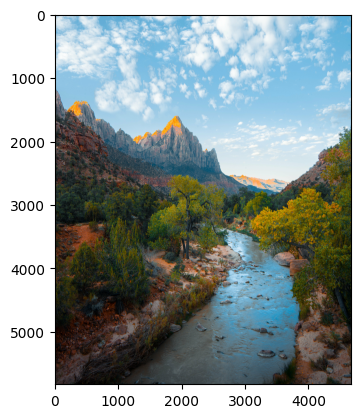

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


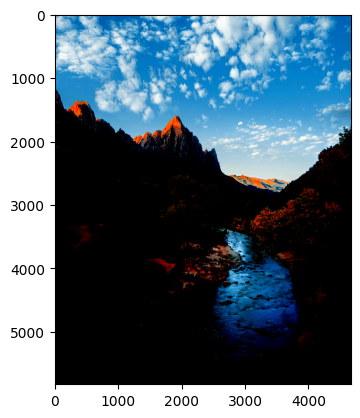

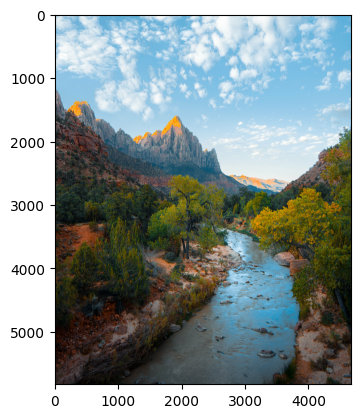

In [24]:
px = 1/plt.rcParams['figure.dpi']  # pixel in inches
plt.imshow(im2)
plt.show()


im2 = normalize(im2)
plt.imshow(im2)
plt.show()

im2 = inverse_normalize(im2)
plt.imshow(im2)
plt.show()
